## Protein Embeddings and Task Model Fitting with BioNeMo

This example notebook shows how to obtain protein learned representations in the form of embeddings using the ESM-1nv pre-trained model. The model is trained with NVIDIA's BioNeMo framework for Large Language Model training and inference. For more details, please visit NVIDIA BioNeMo Service at https://www.nvidia.com/en-us/gpu-cloud/bionemo/ 

This notebook will walk through the task fitting workflow in the following sections:

 - **BioNeMo Service Configuration**
   - Install dependencies and define the BioNeMo service endpoint and API key required for access
 - **Obtaining Protein Embeddings**
   - Define the input dataset of protein sequences
   - Retrive protein embeddings for these sequences using the ESM-1nv model
 - **Training a MLP Classifier to predict protein subcellular location**
   - Use the protein embeddings to train a scikit-learn MLP classifier to predict subcellular location
   - Compare the model results to the ground-truth labels of the input protein sequences
   
## BioNeMo Service Configuration
To get started, please configure and provide your NGC access token by visiting https://ngc.nvidia.com/setup/api-key

In [1]:
API_KEY="<API key>"
API_HOST="https://api.bionemo.ngc.nvidia.com/v1"

Let's start by installing and importing library dependencies. We'll use _requests_ to interact with the BioNeMo service, _BioPython_ to parse FASTA sequences into SeqRecord objects, _scikit-learn_ for classification tasks, and _matplotlib_ for visualization.

In [ ]:
!pip install biopython scikit-learn matplotlib

In [3]:
import io
import re
import time
import numpy
import requests

from typing import Iterable, Dict

# biopython dependency
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

# limiting to the proteins with sequence length<512 for embedding queries
MAX_SEQUENCE_LEN = 510  

Next let's validate our connection to the BioNeMo service. You should get a "200" HTTP response in the following cell, indicating a successful connection. Note the _Authorization_ field in the header response which contains your NGC access token credentials. We'll re-use this header for all future interactions with the service.
<div class="alert alert-block alert-info">
    <b>Tip:</b>  If you do not receive a "200 OK" HTTP response when testing connectivity to BioNeMo service in the cell below, verify
    
 - the API_HOST defined above is the correct address of the BioNeMo service, and
 - the API_KEY is authorized to access BioNeMo service at the API_HOST

Refer to this <a href="https://developer.mozilla.org/en-US/docs/Web/HTTP/Status">list of HTTP responses status codes</a> to help determine the cause of a non-200 response.
</div>

In [ ]:
#Checking to see if the access is configured
response = requests.get(
    f"{API_HOST}/models",
    headers={"Authorization": f"Bearer {API_KEY}"})
print("Query BioNeMo Service:", response)

#Add key to headers for remainder of notebook
headers = {
    'Authorization': f'Bearer {API_KEY}'
}

## Obtaining the protein embeddings using the BioNeMo ESM-1nv model

Using BioNeMo, users can obtain numerical vector representations of protein sequences called embeddings. Protein embeddings can then be used for visualization or making downstream predictions.

Here we are interested in training a neural network to predict subcellular location from an embedding.

The data we will be using comes from the paper [Light attention predicts protein location from the language of life](https://academic.oup.com/bioinformaticsadvances/article/1/1/vbab035/6432029) by Stärk et al. In this paper, the authors developed a machine learning algorithm to predict the subcellular location of proteins from sequence through protein langage models that are similar to those hosted by BioNeMo. Protein subcellular location refers to where the protein _localizes_ in the cell, for example a protein my be expressed in the Nucleus or in the Cytoplasm. Knowing where proteins localize can provide insights into the underlying mechanisms of cellular processes and help identify potential targets for drug development. The following image includes a few examples of subcellular locations in an animal cell:

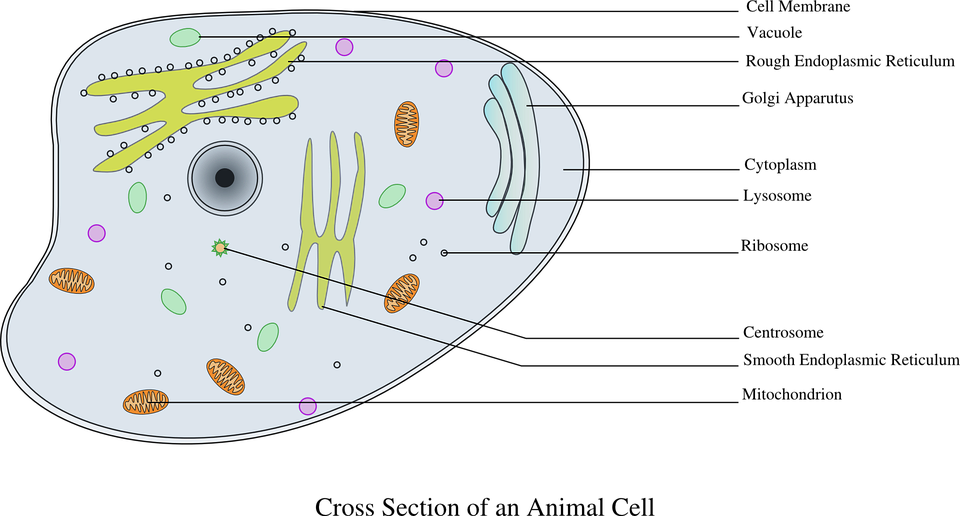  
(Image freely available at https://pixabay.com/images/id-48542)

### Dataset sourcing
For our target input sequences, we will point to FASTA sequences in a benchmark dataset called Fitness Landscape Inference for Proteins (FLIP). FLIP encompasses experimental data across adeno-associated virus stability for gene therapy, protein domain B1 stability and immunoglobulin binding, and thermostability from multiple protein families.



In [4]:
# Example protein dataset location
fasta_url= "http://data.bioembeddings.com/public/FLIP/fasta/scl/mixed_soft.fasta"

First, we define the source of example protein dataset with the FASTA sequences. This data follows the [biotrainer](https://github.com/sacdallago/biotrainer/blob/main/docs/data_standardization.md) standard, so it includes information about the class in the FASTA header, and the protein sequence. Here are two example sequences in this file:

```
>Sequence1 TARGET=Cell_membrane SET=train VALIDATION=False
MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFEDQYTPTIEDFHRKVYNIHGDMYQLDILDTSGNHPFPAM
RRLSILTGDVFILVFSLDSRESFDEVKRLQKQILEVKSCLKNKTKEAAELPMVICGNKNDHSELCRQVPAMEAELLVSGDENC
AYFEVSAKKNTNVNEMFYVLFSMAKLPHEMSPALHHKISVQYGDAFHPRPFCMRRTKVAGAYGMVSPFARRPSVNSDLKYIKA
KVLREGQARERDKCSIQ
>Sequence4833 TARGET=Nucleus SET=train VALIDATION=False
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRFRPGTVALREIRKYQKSTELLIRKLPFQRLVREIAQDFKTDL
RFQSSAVAALQEAAEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
```

Note the following attributes in the FASTA header:
- `TARGET` attribute holds the subcellular location classification for the sequence, for instance `Cell_membrane` and `Nucleus`. This dataset includes a total of ten subcellelular location classes -- more on that below.
- `SET` attribute defines whether the sequence should be used for training (`train`) or testing (`test`)
- `VALIDATION` attribute defines whether the sequence should be used for validation (all sequences where this is `True` are also in `set=train`)

### Downloading the protein sequences and subcellular location annotations

In this step we download the FASTA file defined above and parse the sequences into a list of BioPython `SeqRecord` objects.

In [5]:
# Download the FASTA file from FLIP: https://github.com/J-SNACKKB/FLIP/tree/main/splits/scl
fasta_content = requests.get(fasta_url, headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x86)'
}).content.decode('utf-8')
fasta_stream = io.StringIO(fasta_content)

# Obtain a list of SeqRecords/proteins which contain sequence and attributes
# from the FASTA header
proteins = list(SeqIO.parse(fasta_stream, "fasta"))

### Defining how to retrieve the embeddings from the BioNeMo Server through API calls

Since we are interested in evaluating the protein language model embeddings obtained from the pre-trained ESM-1nv model, we will obtain protein embeddings by making API requests to the NVIDIA BioNeMo Server.

In [6]:
# This is the meat of the notebook -- let's define how to retrieve the embeddings
# and extract TARGET attribute from FASTA headers
def get_per_protein_embeddings(proteins: Iterable[SeqRecord]) -> numpy.array:
    result = list()
    metadata = list()
    batch_size = 32  # Query the ESM-1nv service for embeddings with batches of 32 protein sequences.
    headers = { "Authorization" : f"Bearer {API_KEY}" }

    for index in range(0, len(proteins), batch_size):       

        if (index % 1000 == 0):
            print(f"Processed {index}")
        batch = proteins[index: index+batch_size]
        batch = [x for x in batch if len(str(x.seq)) <= MAX_SEQUENCE_LEN]
        sequences = [str(x.seq) for x in batch]
        
        params = {'sequence': sequences}
        try:
            # Query Embeddings from BioNeMo ESM-1nv service
            response = requests.post(
                f"{API_HOST}/protein-embedding/esm1nv/embeddings",
                json=params,
                headers=headers
            )
            
            if response.status_code != 200:
                print(f"Error querying batch {index}.")
                continue

            embeddings = numpy.load(io.BytesIO(response.content))
            result.extend(embeddings['embeddings'])
            
            # Extract metadata from FASTA -- the FASTA header needs to be biotrainer standard compliant
            for sequence in batch:
                if len(str(sequence.seq)) > MAX_SEQUENCE_LEN:
                    continue
                record_metadata = {
                    key: value for key, value in 
                    re.findall(r"([A-Z_]+)=(-?[A-z0-9]+[.0-9]*)", sequence.description)
                    }
                metadata.append(record_metadata)
        except Exception as ex:
            pass
        
    return numpy.array(result, dtype=object), metadata

### Retrieving the embeddings

Warning: this could take some minutes. We accept a bit of data loss (i.e. failing batches), as sometimes sequences include invalid characters that were not included in the model training set.

In [ ]:
protein_embeddings, metadata = get_per_protein_embeddings(proteins)

### Inspecting the embeddings and labels

Embeddings returned from the BioNeMo server are vectors of fixed size for each input sequence. In other words, if we input 10 sequences, we will obtain a matrix `10xD`, where `D` is the size of the embedding (in the case of ESM-1nv, `D=768`).  At a glance, these real-valued vector embeddings don't show any obvious features (see the printout in the next cell).  But these vectors do contain information that can be used in downstream models to reveal properties of the protein, for example the subcellular location as we'll explore below.

In [ ]:
display(protein_embeddings[:2], protein_embeddings.shape)

Let's enumerate the labels corresponding to potential subcellular locations.

In [9]:
# Let's also print all the labels

labels = set([meta['TARGET'] for meta in metadata])

for i, label in enumerate(labels):
    print(f"{i+1}. {label.replace('_', ' ')}")

1. Nucleus
2. Plastid
3. Golgi apparatus
4. Endoplasmic reticulum
5. Cytoplasm
6. Lysosome
7. Mitochondrion
8. Cell membrane
9. Peroxisome
10. Extracellular


## Training a MLP to predict subcellular location

To be able to classify proteins for their subcellular location, we train a simple scikit-learn Multi-layer Perceptron (MPL) classifier.  The MLP model uses a network of hidden layers to fit the input embedding vectors to the model classes (the cellular locations above).  In the call below, we define the MLP to use the Adam optimizer with a network of 32 hidden layers, defining a random state (or seed) for reproducibility, and trained for a maximum of 500 iterations.

In [10]:
# Prepare the data for training
X_train = list()
y_train = list()

X_test = list()
y_test = list()

for embedding, record_metadata in zip(protein_embeddings, metadata):
    if record_metadata['SET'] == 'train':
        X_train.append(embedding)
        y_train.append(record_metadata['TARGET'])
    elif record_metadata['SET'] == 'test':
        X_test.append(embedding)
        y_test.append(record_metadata['TARGET'])

In [ ]:
print(f"There are {len(X_train)} training samples and {len(X_test)} testing samples.")

In [ ]:
multilayerperceptron = MLPClassifier(solver='adam', hidden_layer_sizes=(32,), random_state=10, max_iter=500)
multilayerperceptron.fit(X_train, y_train)

In [ ]:
predicted_testing_labels = multilayerperceptron.predict(X_test)
accuracy = accuracy_score(y_test, predicted_testing_labels)

print(f"Our model has an accuracy of {(accuracy*100):.2f}%")

In [14]:
label_list = list(labels)

confusion_matrix_data = confusion_matrix(y_test, predicted_testing_labels, labels=label_list, normalize='true')

The last call in the cell above constructs a confusion matrix using the predicted classes from the MLP model.  This confusion matrix shows the accuracy of the model by comparing the predicted values (y-axis) to the ground truth (x-axis) from the initial protein sequence labels.  A model that performs with 100% accuracy would result in a confusion matrix with a perfect diagonal line, whereas a model with no predictive ability (random) would show gray noise across the graph.  We can plot our confusion matrix below to see that this MLP does a reasonably good job predicting the protein's subcellular location from the embedding vectors of the input protein sequences.

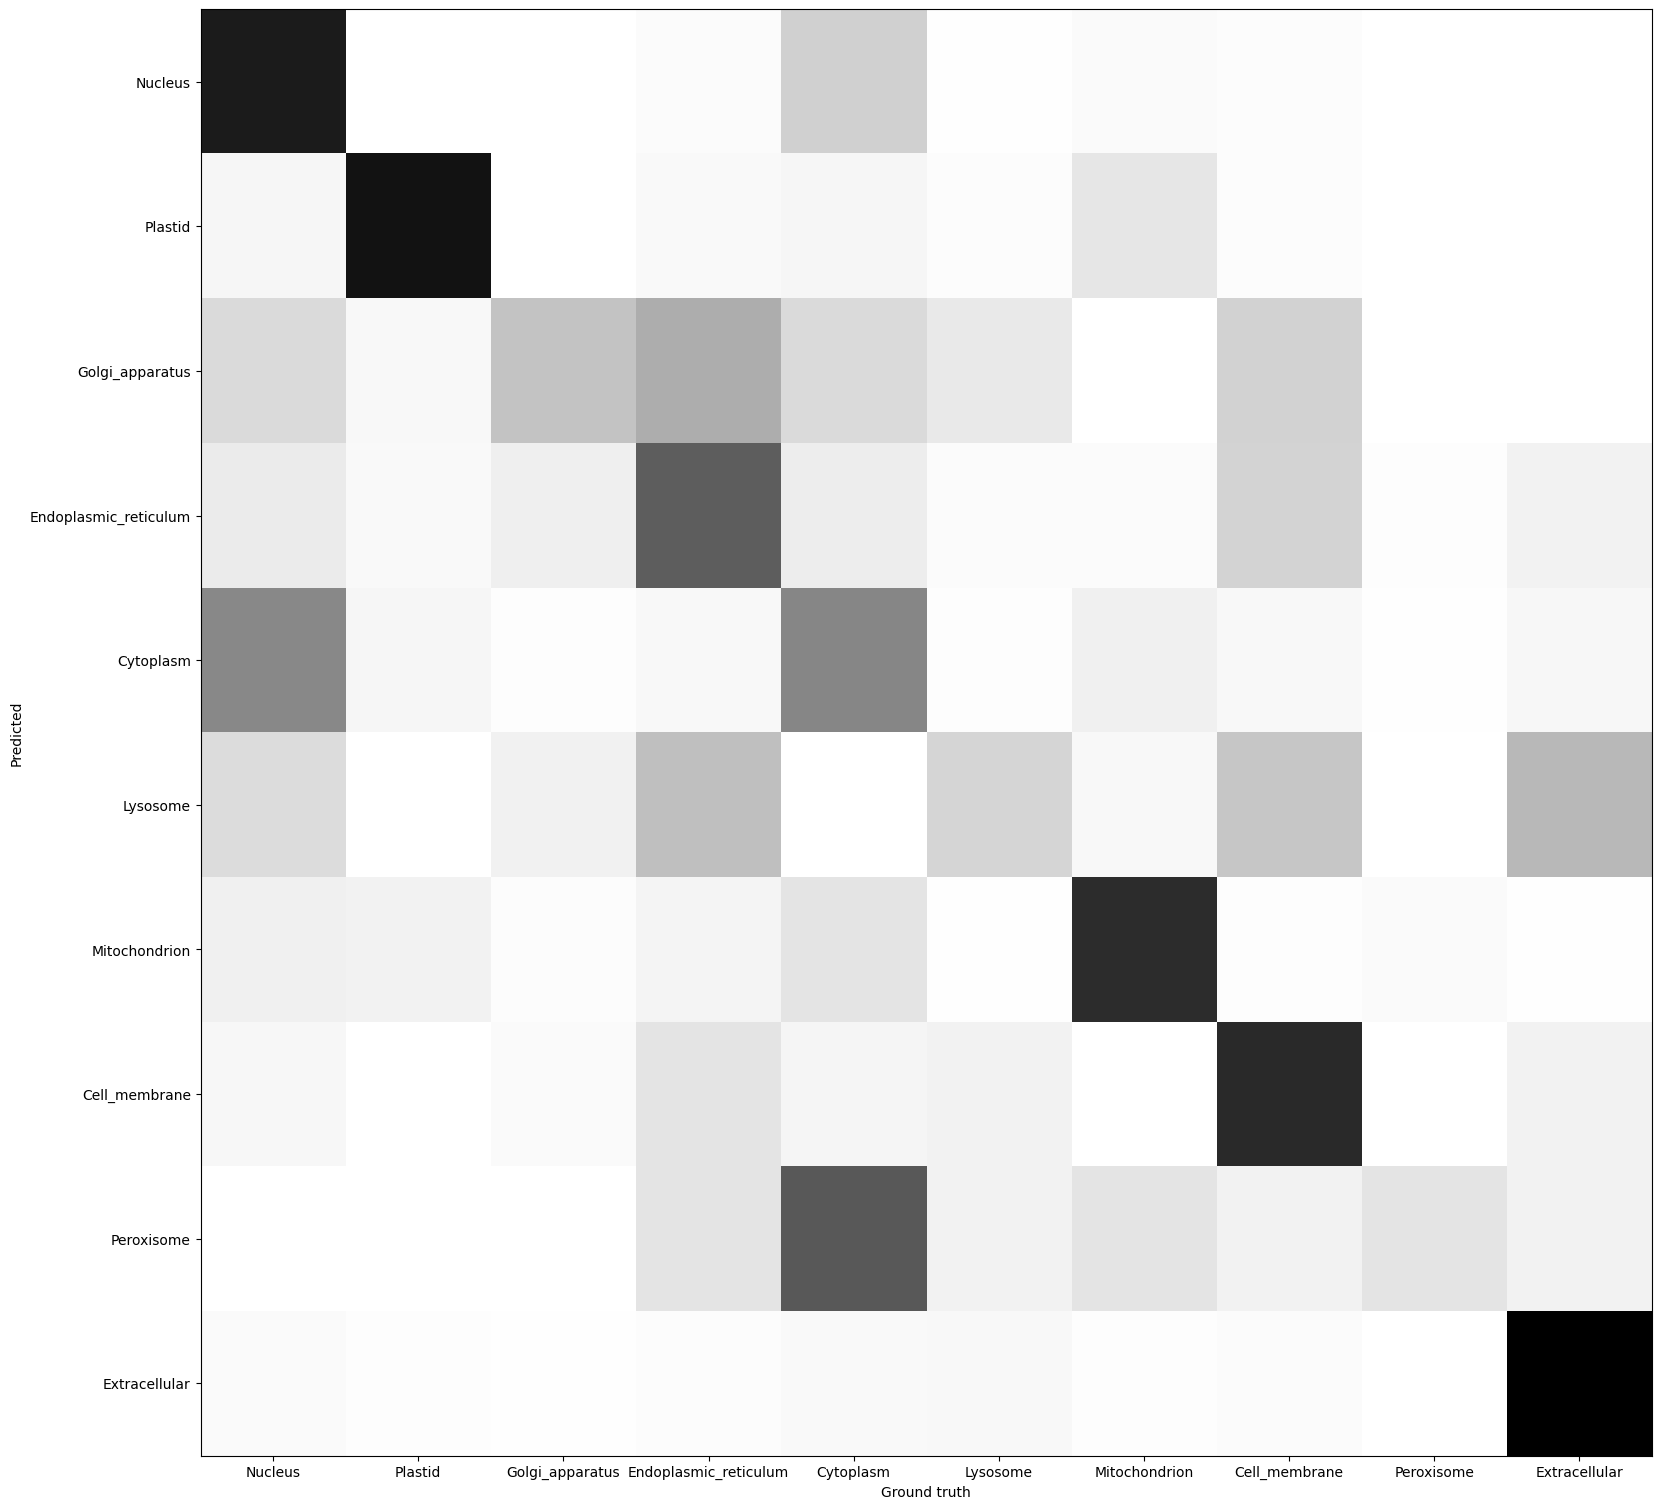

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(confusion_matrix_data, cmap=plt.cm.gist_yarg, interpolation='nearest', aspect='auto')

plt.tight_layout()

plt.xlabel('Ground truth')
plt.ylabel('Predicted')

plt.xticks([i for i in range(10)], [label_list[i] for i in range(10)])
plt.yticks([i for i in range(10)], [label_list[i] for i in range(10)])

fig.show()

## Conclusion
In this notebook, we've covered:
 - How to configure the BioNeMo Service API
 - Used the BioNeMo API to retrieve protein embeddings using the ESM-1nv model
 - Trained a simple classifier to predict protein subcellular location from the learned embeddings

This is a relatively simple workflow that demonstrates how the BioNeMo service can be used to quickly and easily retrieve learned embeddings from a set of input protein sequences.  The significance of this workflow is not just in the simplicity of generating protein embeddings with the BioNeMo service API, but also in the utility of these embeddings.  We've shown how these learned embeddings can be used to predict subcellular location.  These same embeddings can be used for a range of additional downstream predictive tasks like 3D protein structure or functional features, protein-ligand interactions, and other properties useful in drug discovery.